# 0.0. Imports & Dados

In [2]:
import pandas as pd
import inflection
import math
import numpy as np
import seaborn as sns
sns.set()
sns.set({'figure.figsize': (20, 12)})
from matplotlib import pyplot as plt
from IPython.display import Image
import warnings
warnings.filterwarnings( 'ignore' )
pd.set_option('display.max_columns', None)
from datetime import datetime
from datetime import timedelta

## 0.1. Funções auxiliares

## Carregamento dos Dados

In [2]:
df_sales_raw = pd.read_csv( 'data/train.csv', low_memory=False )
df_store_raw = pd.read_csv( 'data/store.csv', low_memory=False )

# merge
df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on='Store' )

# 1.0. Descrição dos Dados

In [3]:
df1 = df_raw.copy()

## 1.1. Renomear Colunas

In [4]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo','StateHoliday', 'SchoolHoliday', 'StoreType',             'Assortment','CompetitionDistance', 'CompetitionOpenSinceMonth','CompetitionOpenSinceYear', 'Promo2',                         'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore( x )

cols_new = list(map( snakecase, cols_old ))

# rename
df1.columns = cols_new

## 1.2. Dimensão dos Dados

In [5]:
print(f'Number of Rows: {df1.shape[0]}')
print(f'Number of Columns: {df1.shape[1]}')

Number of Rows: 1017209
Number of Columns: 18


## 1.3. Data Types

In [6]:
df1['date'] = pd.to_datetime( df1['date'] )

df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Checando NA

In [7]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Preenchendo NA

In [8]:
#competition_distance
df1['competition_distance'] = df1['competition_distance'].apply( lambda x:
                                                                    200000.0 if math.isnan( x ) else x )

#competition_open_since_month
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month 
                                                if math.isnan( x['competition_open_since_month'] )
                                                else x['competition_open_since_month'], axis = 1 )

#competition_open_since_year
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year 
                                                if math.isnan( x['competition_open_since_year'] )
                                                else x['competition_open_since_year'], axis = 1 )

#promo2_since_week
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week 
                                                if math.isnan( x['promo2_since_week'] )
                                                else x['promo2_since_week'], axis = 1 )

#promo2_since_year
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year 
                                                if math.isnan( x['promo2_since_year'] )
                                                else x['promo2_since_year'], axis = 1 )

#promo_interval
month_map = { 1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
              7: 'Jul', 8: 'Aug', 9: 'Sept', 10: 'Oct', 11: 'Nov', 12: 'Dec' }

df1['promo_interval'] = df1['promo_interval'].fillna(0)

df1['month_map'] = df1['date'].dt.month.map( month_map )

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 
                                            0 if x['promo_interval'] == 0 else 1 
                                            if x['month_map'] in x['promo_interval'].split( ',' ) 
                                            else 0, axis=1)


In [9]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6. Arrumando Types

In [10]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( np.int64 )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( np.int64 )

df1['promo2_since_week'] = df1['promo2_since_week'].astype( np.int64 )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( np.int64 )

In [11]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7. Estatística Descritiva

In [12]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

### 1.7.1 Atributos Numéricos

In [13]:
# Central Tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T     # range
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenate

m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis'] 

In [14]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


### 1.7.2 Atributos Categóricos

In [15]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

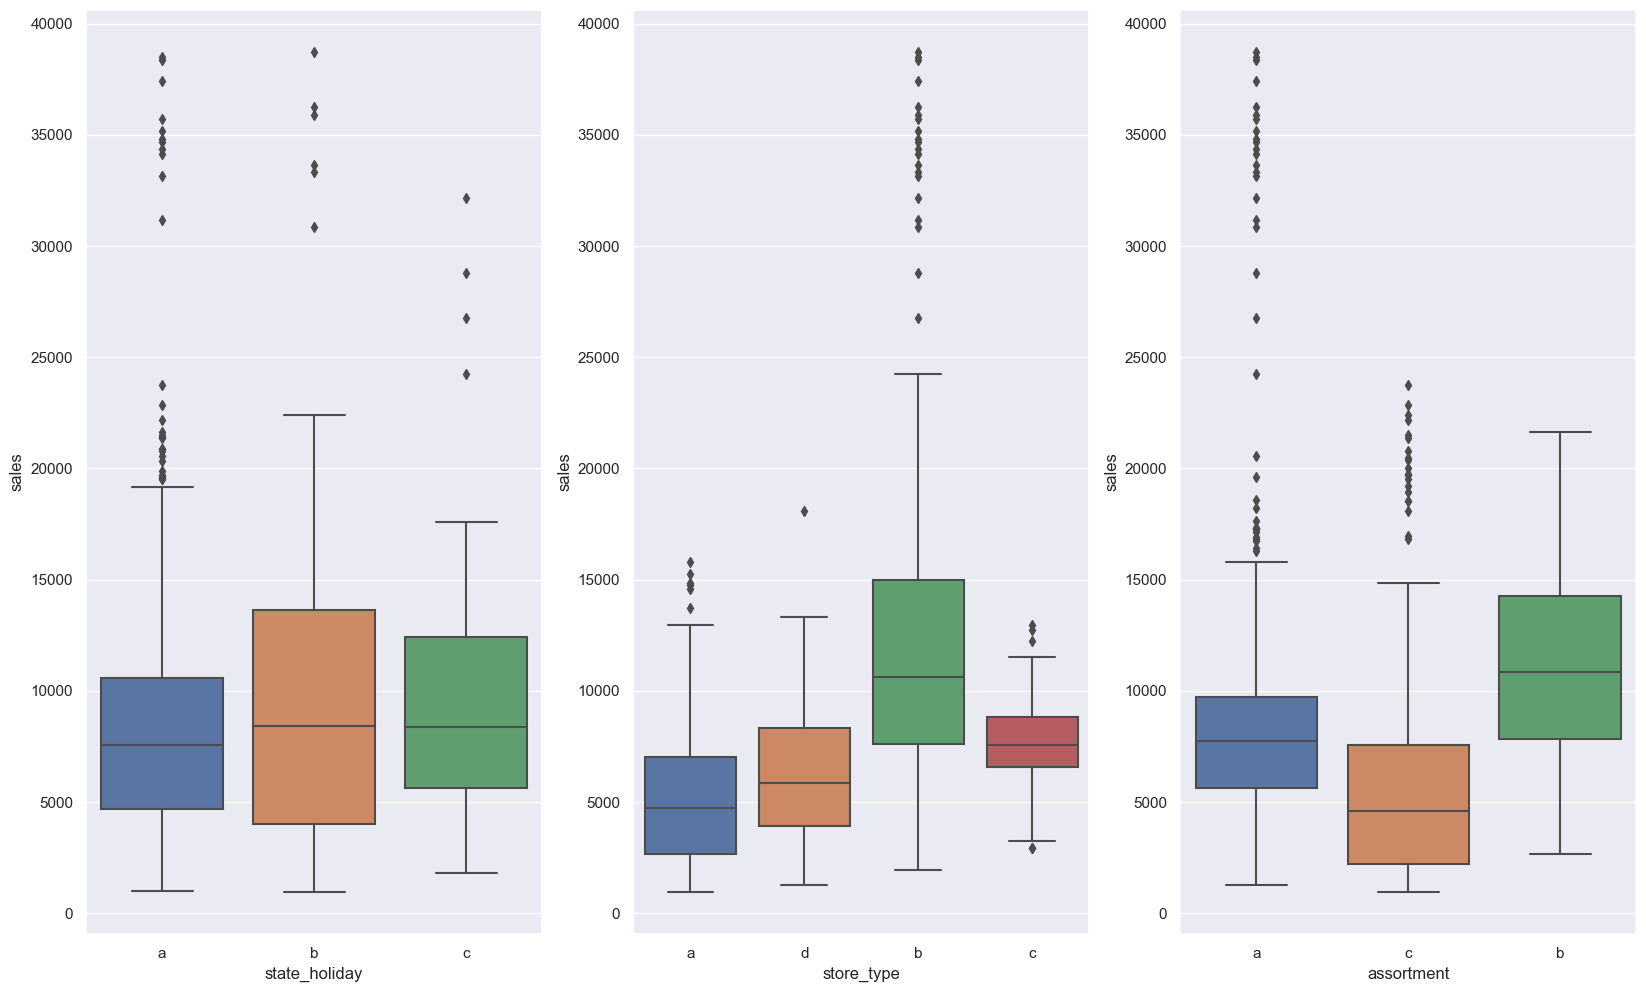

In [16]:
aux1 = df1[ ( df1['state_holiday'] != '0' ) & ( df1['sales'] > 0 ) ]

plt.subplot( 1, 3, 1 )
sns.boxplot( x='state_holiday', y='sales', data=aux1)

plt.subplot( 1, 3, 2 )
sns.boxplot( x='store_type', y='sales', data=aux1)

plt.subplot( 1, 3, 3 )
sns.boxplot( x='assortment', y='sales', data=aux1);

# 2.0. Feature Engineering

In [2]:
# Salvei o df1 como um arquivo csv, para não precisar rodar tudo novamente
df2 = pd.read_csv( 'data/df2.csv', low_memory=False )
df2['date'] = pd.to_datetime( df2['date'] )

## 2.1. Mapa Mental de Hipóteses

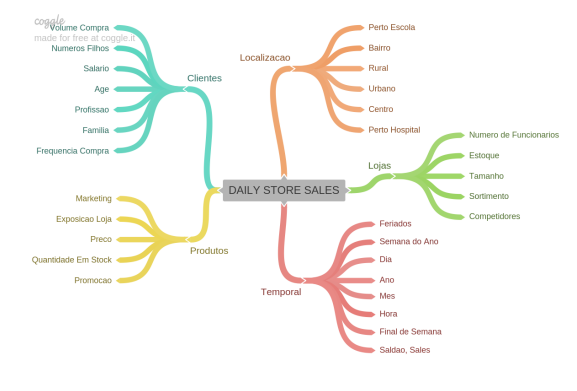

In [5]:
# Mapa Mental de Hipóteses
Image( 'img/image.png' )

## 2.2. Criação de Hipóteses

### 2.2.1 Hipóteses Lojas

**1.** Lojas com maior número de funcionarios deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimento deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores a mais tempo deveriam vender mais.

### 2.2.2 Hipóteses Produto

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas que com maior exposição do produto deveriam vender mais.

**3.** Lojas com produtos com preço menor deveriam vender mais.

**4.** Lojas com promoções mais agressivas ( desconto maiores ) deveriam vender mais.

**5.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**6.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções conseccitivas deveriam vender mais.

### 2.2.3 Hipóteses Temporal

**1.** Lojas que abrem no feriado do Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam venderm mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depos do dia 10 de cada mês.

**5.** Lojas deveriam vender menos nos finais de semana.

**6.** Lojas deveriam vender menos nos feriados escolares.

## 2.3. Lista Final de Hipóteses

**1.** Lojas com maior sortimento deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores a mais tempo deveriam vender mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções conseccitivas deveriam vender mais.

**7.** Lojas que abrem no feriado do Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam venderm mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depos do dia 10 de cada mês.

**11.** Lojas deveriam vender menos nos finais de semana.

**12.** Lojas deveriam vender menos nos feriados escolares.

## 2.4. Feature Engineering

In [4]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# competition since
df2['competition_since'] = df2.apply( lambda x:
                             datetime( year=x['competition_open_since_year'],                                      month=x['competition_open_since_month'], day=1 ), axis=1 )

df2['competition_since_month'] = ( ( df2['date'] - df2['competition_since'] ) / 30 ).apply(                                                                  lambda x: x.days ).astype(int)
# promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )

df2['promo_since'] = df2['promo_since'].apply( 
                              lambda x: datetime.strptime( x + '-1', '%Y-%W-%w' ) - timedelta( days = 7 ) )

df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

# assortment
df2['assortment'] = df2['assortment'].apply( 
                            lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( 
             lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

# 3.0. Filtragem de Dados

In [3]:
df3 = pd.read_csv( 'data/df3.csv' )
df3['date'] = pd.to_datetime( df3['date'] )
df3['competition_since'] = pd.to_datetime( df3['competition_since'] )
df3['promo_since'] = pd.to_datetime( df3['promo_since'] )

## 3.1. Filtragem de Linhas

In [8]:
df3 = df3[( df3['open'] != 0 ) & ( df3['sales'] > 0 )]

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_since_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016776,682,2,2013-01-01,3375,566,1,0,public_holiday,1,b,basic,150.0,9,2006,0,1,2013,0,Jan,0,2013,1,1,1,2013-00,2006-09-01,77,2012-12-31,0
1016827,733,2,2013-01-01,10765,2377,1,0,public_holiday,1,b,extra,860.0,10,1999,0,1,2013,0,Jan,0,2013,1,1,1,2013-00,1999-10-01,161,2012-12-31,0
1016863,769,2,2013-01-01,5035,1248,1,0,public_holiday,1,b,extra,840.0,1,2013,1,48,2012,"Jan,Apr,Jul,Oct",Jan,1,2013,1,1,1,2013-00,2013-01-01,0,2012-11-19,6
1017042,948,2,2013-01-01,4491,1039,1,0,public_holiday,1,b,extra,1430.0,1,2013,0,1,2013,0,Jan,0,2013,1,1,1,2013-00,2013-01-01,0,2012-12-31,0


## 3.2. Seleção de Colunas

In [10]:
cold_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop( cold_drop, axis=1 )